# Delhi Climate Forecasting: Time Series Analysis and Modeling
*Project Overview*

This project focuses on forecasting Delhi's climate using advanced time series methods. The goal is to analyze and model historical climate data to predict future trends.

*Dataset*

The dataset spans from January 1, 2013, to April 24, 2017, with daily observations of four key features:

Mean Temperature: Average temperature for the day
Humidity: Relative humidity level
Windspeed: Average wind speed
Mean Pressure: Average atmospheric pressure
Time Series Analysis and EDA

Given the temporal nature of the data, time series techniques are employed for visualization and exploratory data analysis (EDA). This includes:

Seasonality and Trends: Identifying recurring patterns and long-term trends in the data.
Decomposition: Breaking down the time series into its components (trend, seasonality, and residual).
Data Preparation for Modeling

*The data is prepared for modeling by:*

Feature Engineering: Creating additional features if necessary (e.g., lagged values, derived variables).
Data Splitting: Dividing the data into training and testing sets.
Forecasting Methods

*Four forecasting methods are implemented:*

    Naive Forecasting: A simple baseline method that predicts the next value as the previous value.
    ARIMA (Autoregressive Integrated Moving Average): A statistical model that uses past values to predict future values.
    ETS (Exponential Smoothing): A statistical method that models the trend, seasonality, and residual components of the time series.
    Deep Learning (RNN and LSTM): Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks are suitable for time series and sequential data. They can capture complex patterns and dependencies in the data.
    
Note: The choice of forecasting method depends on the specific characteristics of the data and the desired level of accuracy

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error , r2_score

plt.style.use('bmh')

In [2]:
data_train = pd.read_csv('DailyDelhiClimateTrain.csv' , index_col='date' , parse_dates=['date'])
data_test = pd.read_csv('DailyDelhiClimateTest.csv' , index_col = 'date' , parse_dates=['date'])

data_train.rename(columns = {'meantemp':'temp'} , inplace = True)
data_test.rename( columns =  {'meantemp':'temp'} , inplace = True)

data_train.shape , data_test.shape

((1462, 4), (114, 4))

In [3]:
data_train

,temp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


In [4]:
df_info = pd.concat([data_train.isna().sum() , data_train.nunique() , data_train.dtypes] , axis = 1)
df_info.columns = ['missing' , 'n unique' , 'dtype']
df_info

,missing,n unique,dtype
temp,0,617,float64
humidity,0,897,float64
wind_speed,0,730,float64
meanpressure,0,626,float64


In [5]:
# no missing value , no categorical 

## EDA

In [6]:
df = data_train.copy()

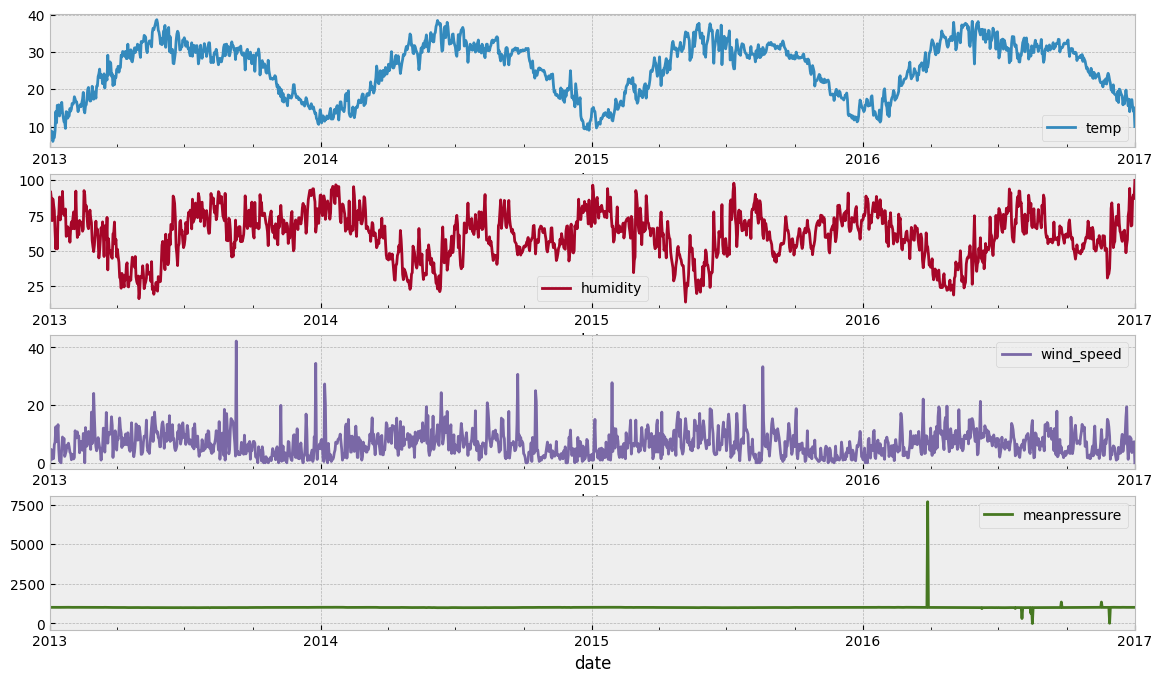

In [7]:
df.plot(subplots = True , layout = (4,1) , figsize = (14,8) , sharex= False)
plt.show()

it is obvious , there is yearly seasonal , and there is anomoly in mean pressure

### error and outlier handeling

In [8]:
df['meanpressure'].describe()

count    1462.000000
mean     1011.104548
std       180.231668
min        -3.041667
25%      1001.580357
50%      1008.563492
75%      1014.944901
max      7679.333333
Name: meanpressure, dtype: float64

### lowest recorded pressure in the world is 870 in pacific ocean
### and heights is 1083 in seberia , russia
so i limit mean pressure , with these value , and it is obvious these pressure are errors . (maybe input entry error) negative pressure -3 is impossible , 7679 is impossible too. and the others.
i decided the replace these value with mean pressure of cleaned dataframe(first i drop these value , then calculate mean for pressur )

In [9]:
df_errors = df[(df['meanpressure'] < 900) | (df['meanpressure']>1083)]
df_errors

,temp,humidity,wind_speed,meanpressure
date,,,,
2016-03-28,25.933333,52.800000,6.546667,7679.333333
2016-08-02,30.687500,72.125000,6.375000,310.437500
2016-08-14,28.933333,83.700000,6.370000,633.900000
2016-08-16,31.333333,66.416667,14.666667,-3.041667
2016-09-24,31.240000,66.480000,5.496154,1352.615385
2016-11-17,21.730769,51.730769,11.550000,1350.296296
2016-11-28,22.454545,37.318182,9.185714,12.045455


In [10]:
df_cleaned = df.drop(df_errors.index , axis = 0)                    # dataframe with no errors
mean_pressure_modified = df_cleaned['meanpressure'].mean()          # mean of cleaned dataframe
df.loc[df_errors.index , 'meanpressure'] = mean_pressure_modified   # impute with error pressure

array([[<Axes: xlabel='date'>, <Axes: xlabel='date'>],
       [<Axes: xlabel='date'>, <Axes: xlabel='date'>]], dtype=object)

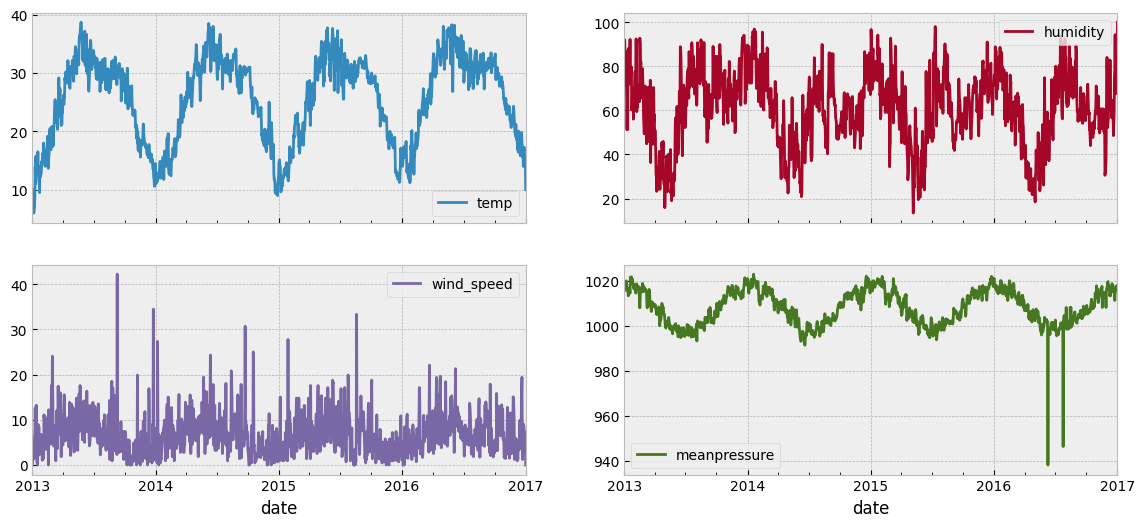

In [11]:
df.plot(subplots = True , layout = (2,2) , figsize = (14,6))

In [12]:
df['meanpressure'].describe()

count    1462.000000
mean     1008.178187
std         7.808525
min       938.066667
25%      1001.625000
50%      1008.500000
75%      1014.875000
max      1023.000000
Name: meanpressure, dtype: float64

Text(0.5, 1.0, 'mean pressure after cleaning')

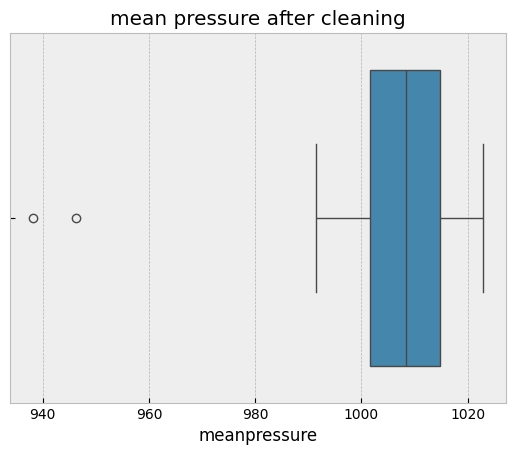

In [13]:
sns.boxplot(df , x = 'meanpressure')
plt.title('mean pressure after cleaning')
# there is 2 outlier

In [14]:
# create weekly and monthly time frame
df_weekly = df.resample('W').mean()
df_monthly = df.resample('ME').mean()

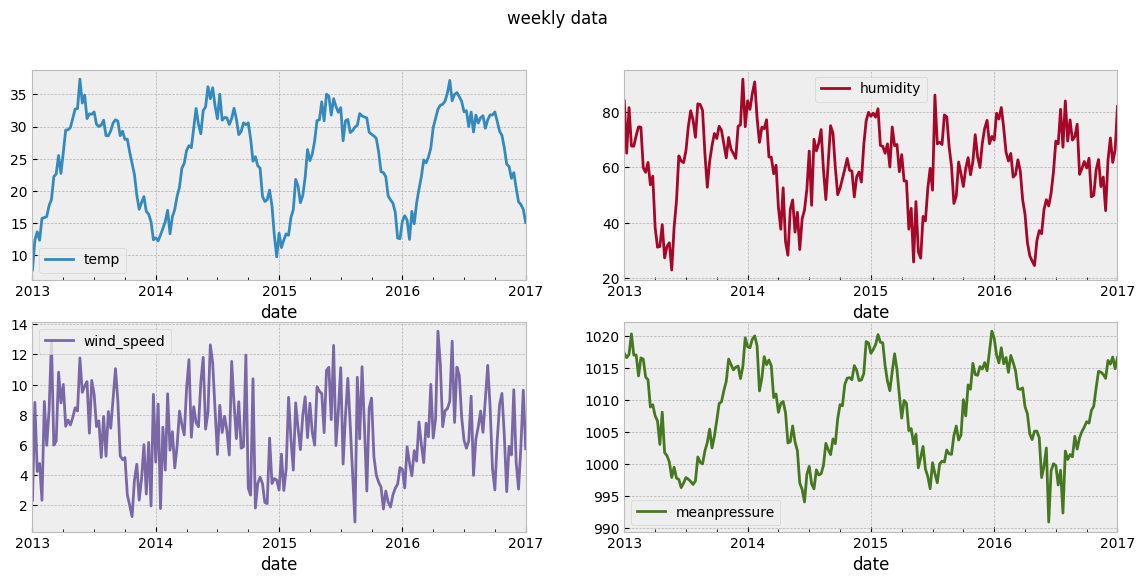

In [15]:
# to reduce noise and make it smoother we draw weekly data
df_weekly.plot(subplots = True , layout = (2,2) , 
                figsize = (14,6) , title = 'weekly data' , sharex=False)
plt.show()

In [16]:
# draw weekly data , with their trands ( moving average 28 week)
MA28 = df_weekly.rolling(window=28).mean()

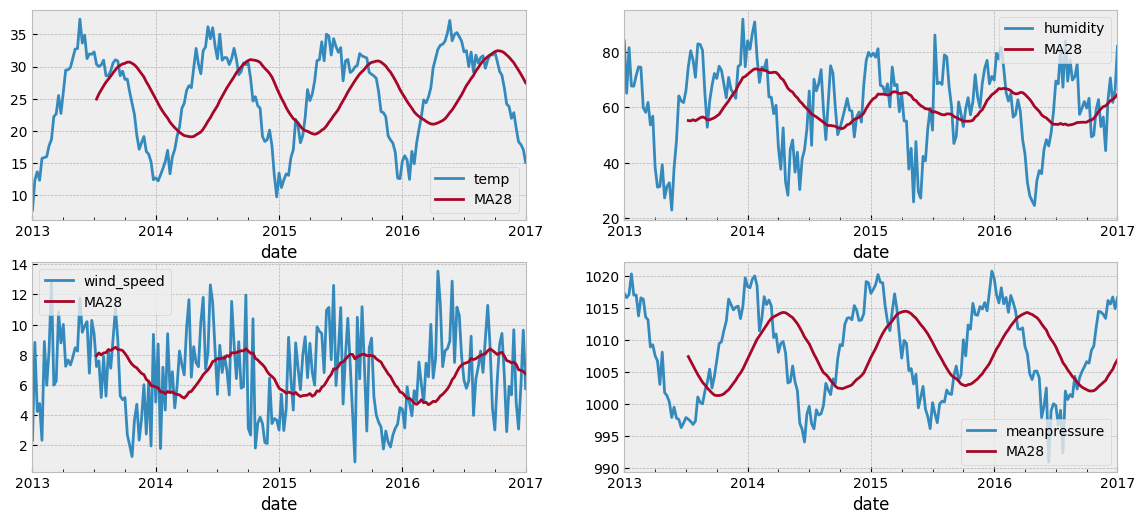

In [17]:
# alternative way to draw , we need this because there is moving average plot
fig , ax = plt.subplots(nrows = 2 , ncols=2 ,figsize = (14,6))
for ax , col in zip(ax.flat , df.columns):
    df_weekly[col].plot(ax = ax , legend = col)
    MA28[col].plot(ax = ax  , label = 'MA28')
    ax.legend()

### show distribution by month

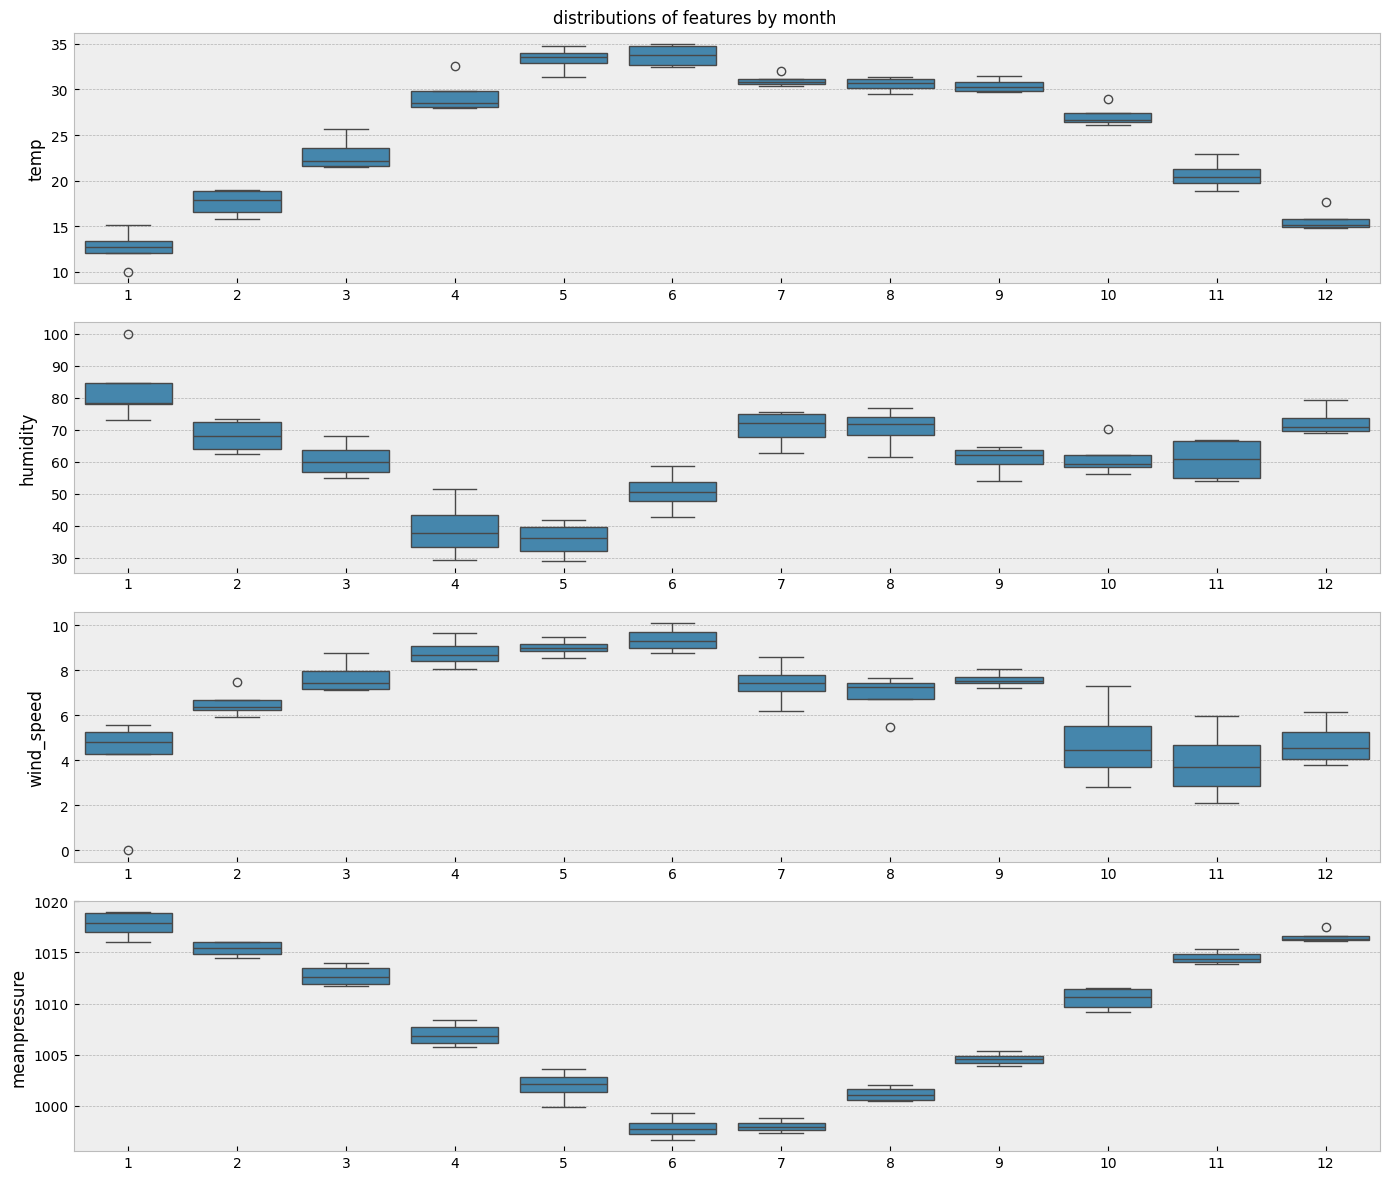

In [18]:
fig , ax = plt.subplots(4,1,figsize = (14,12) )
for ax , col in zip(ax.flat , df.columns):
    sns.boxplot(df_monthly , y = col , x=df_monthly.index.month  , ax = ax)
    ax.set_xlabel('')
plt.suptitle('distributions of features by month') , plt.tight_layout()
plt.show()

## correlation

In [19]:
df_corr = df.corr()
mask = np.tril( np.ones(df_corr.shape) , k = -1).astype(bool)
df_corr = df_corr.where(mask)
df_corr

,temp,humidity,wind_speed,meanpressure
temp,NaN,NaN,NaN,NaN
humidity,-0.571951,NaN,NaN,NaN
wind_speed,0.306468,-0.373972,NaN,NaN
meanpressure,-0.846209,0.317867,-0.277286,NaN


(<Axes: title={'center': 'correlation'}>, Text(0.5, 1.0, 'correlation'))

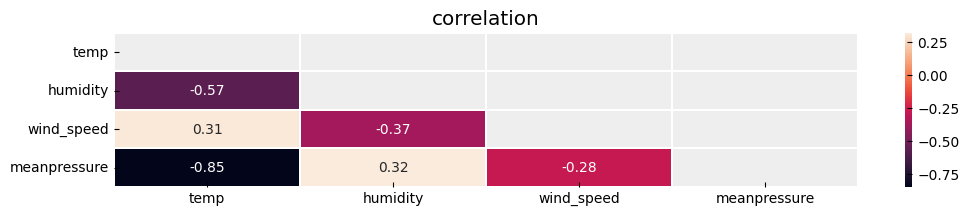

In [20]:
plt.figure(figsize = (12,2)) , plt.grid()
sns.heatmap(df_corr , annot =True ,linewidths=0.1) , plt.title('correlation')

### feature relation ship and histograms

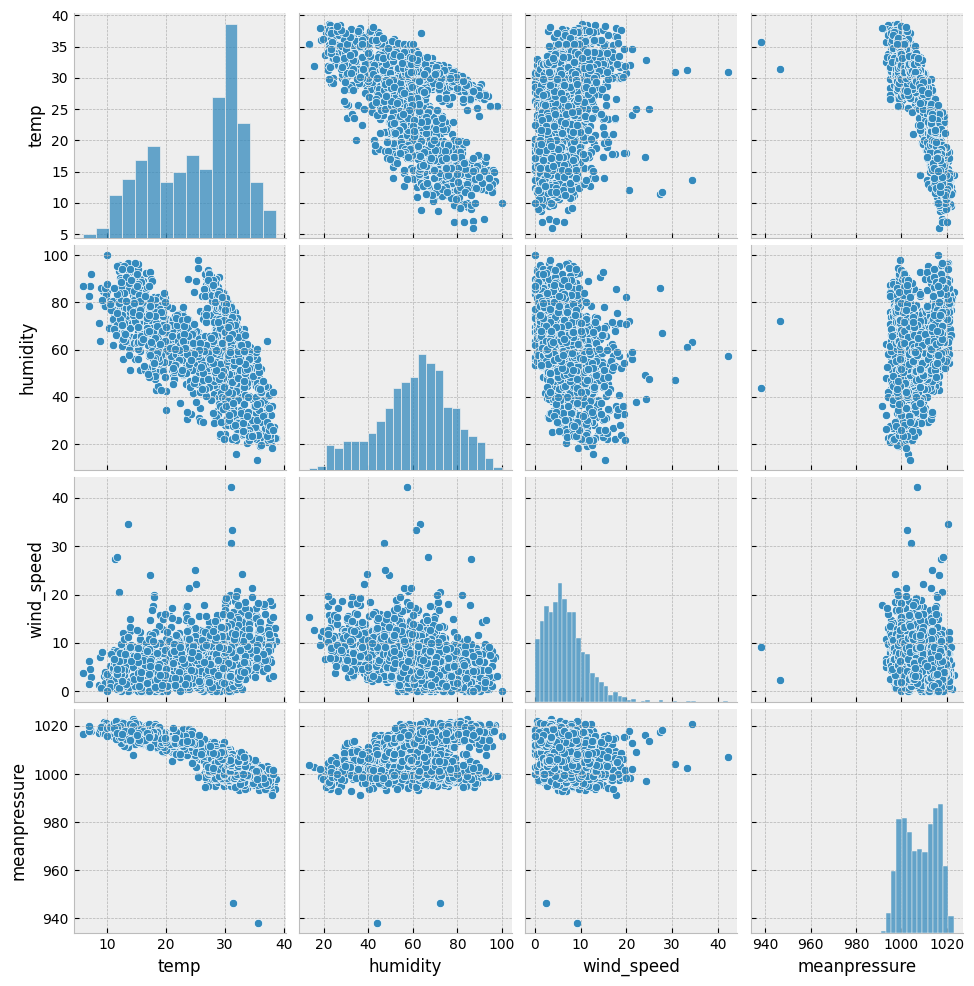

In [21]:
sns.pairplot(df)
plt.show()

### monthly average

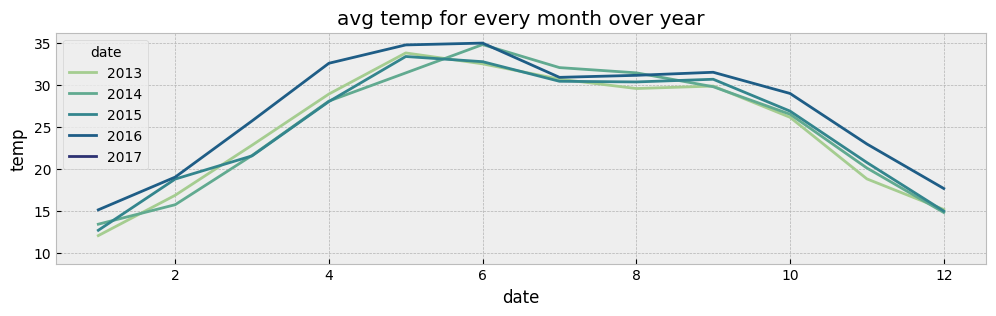

In [22]:
plt.figure(figsize = (12,3))
sns.lineplot(df ,x = df.index.month ,y = 'temp' , hue = df.index.year , 
             palette='crest' , errorbar = None)
plt.title('avg temp for every month over year')
plt.show()

# seasonality
### decompose seasonality , trend for temp

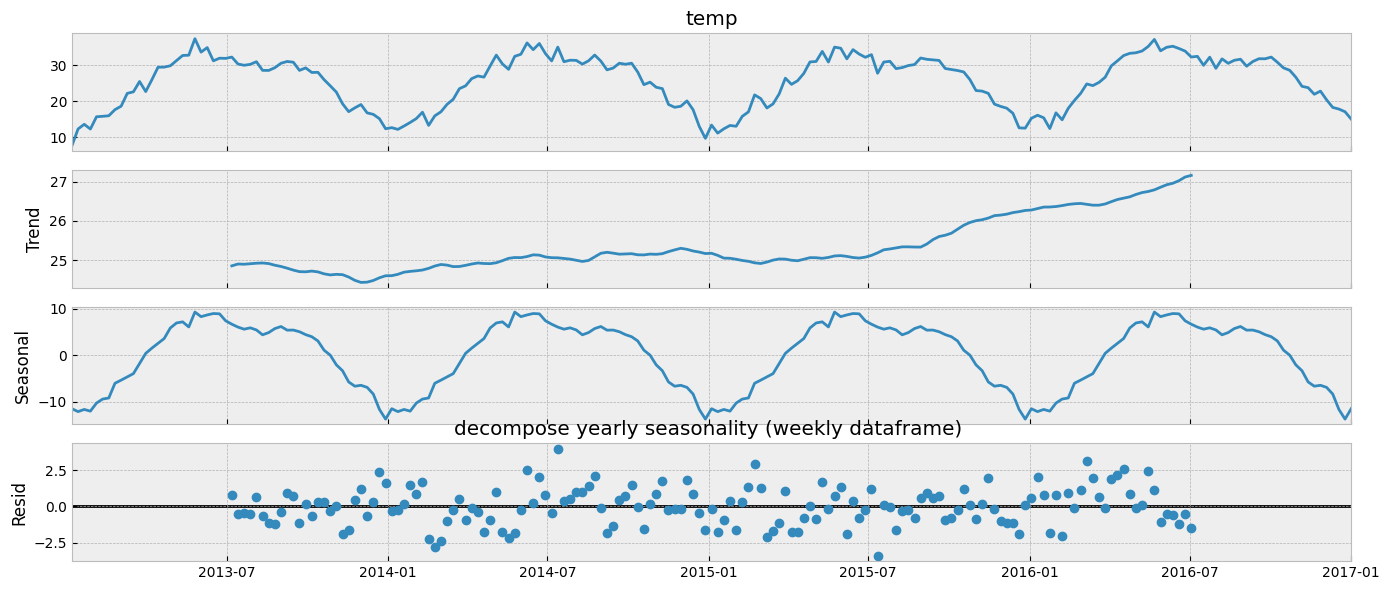

(Text(0.5, 1.0, 'decompose yearly seasonality (weekly dataframe) '), None)

In [23]:
plt.rcParams['figure.figsize'] = (14,6)   
# decompose create small fig , we must change matplotlib default setting , then reset it
decompose_temp = sm.tsa.seasonal_decompose(df_weekly['temp'])
decompose_temp.plot()
plt.title('decompose yearly seasonality (weekly dataframe) ') , plt.show()

## seasonality for all features

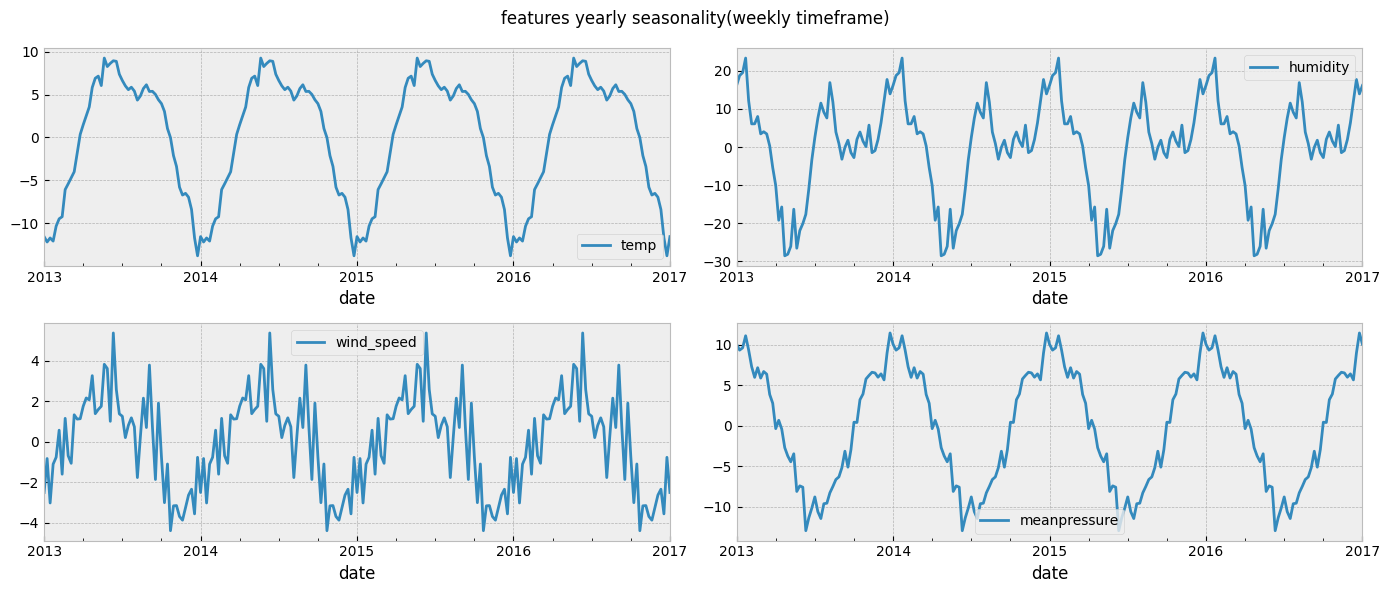

In [24]:
fig ,ax = plt.subplots(2,2)
for ax , col in zip(ax.flat , df.columns):
    decompose= sm.tsa.seasonal_decompose(df_weekly[col])
    decompose.seasonal.plot(ax = ax , label = col)
    ax.legend()
    plt.tight_layout()
    plt.suptitle('features yearly seasonality(weekly timeframe)')

### there is yearly seasonality for all feature   ,wind speed seasonality is more noisier 

### check for weekly seasonality
important : we need to take smaller observation period, lets take 6 month
we do this , because for all data , we can not visulize daily timeframe 

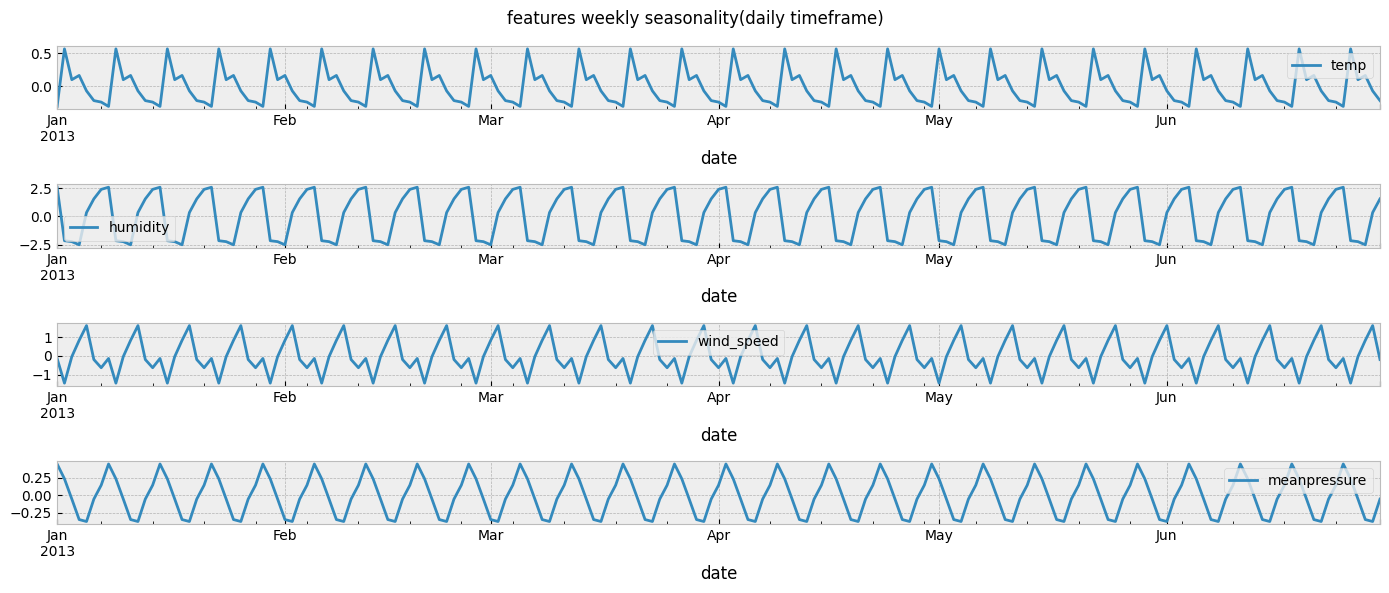

In [25]:
period = slice( '2013-01' ,'2013-06' )   # 6 month
fig ,ax = plt.subplots(4,1)    # order of subplots changed , to see wider observation 
for ax , col in zip(ax.flat , df.columns):
    decompose= sm.tsa.seasonal_decompose(df[period][col])   # notice , it is daily data for 6 month
    decompose.seasonal.plot(ax = ax , label = col)
    ax.legend()
    plt.tight_layout()
    plt.suptitle('features weekly seasonality(daily timeframe)')

### there is weekly seasonality for first 6 month
### i checkd period for others 6 monthes of years ,there is weekly seasonality , but different patterns
####  due to verbosity , i skipped to plot them

## trend

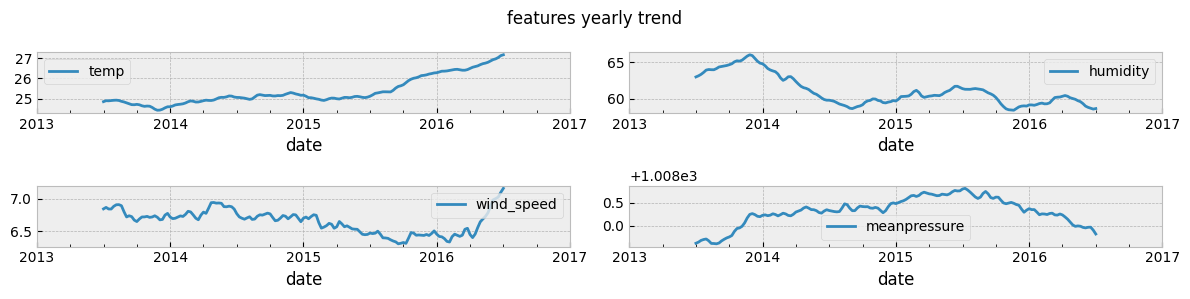

In [26]:
fig ,ax = plt.subplots(2,2 , figsize = (12,3))
for ax , col in zip(ax.flat , df.columns):
    decompose= sm.tsa.seasonal_decompose(df_weekly[col])
    decompose.trend.plot(ax = ax , label = col)
    ax.legend()
    plt.tight_layout()
    plt.suptitle('features yearly trend')

# Modeling

there is 4 main approach for timeseries forecasting<br>
we forecast one step forecasting ( forecast tommorrow's temp)
1. simple : naive , average forecasting
2. ARIMA , SARIMA
3. ETS : error , trend , season , exponential smoothing
4. Deep : RNN , LSTM

In [27]:
## build a empty list , to add metrics scores for final comparison
#metrics dictionary will append to this list
model_performance = []

## metrics function for evaluate mae , mape , r2 score

In [28]:
# metric function
def metrics_3(y_true , y_pred , model):
    mae = mean_absolute_error(y_true , y_pred )
    mape = mean_absolute_percentage_error(y_true , y_pred )
    r2 = r2_score(y_true , y_pred )
    
    metric_dict = {
        'model':model ,
        'mae': f'{mae:0.2f}',
        'mape':f'{100*mape:0.2f}%',
        'r2': f'{100*r2:0.2f}%'
    }
    return metric_dict

In [29]:
# comibe train and test dataset
df_all = pd.concat([df , data_test])
# train and test dataset is common in joining index , it is duplicated , must be removed 2017-01-01
duplicated_index = df_all[df_all.index.duplicated()]
df_all = df_all[~df_all.index.duplicated(keep='last')]
#df_all

# naive forecastin

#### YEARLY seasonality , naive forecasting for 1 previous year period

In [30]:
# mae
diff_1y = df_all['temp'].diff(365)
mae = diff_1y.abs().mean()
print(f'mean absolute error for naive forecasting period of 1 week = {mae:0.2f}')

mean absolute error for naive forecasting period of 1 week = 2.56


In [31]:
# alternative method
df_naive = df_all.shift(365)
score_naive = metrics_3(df_all['temp'][365:] , df_naive['temp'][365:] , 'naive')    # [365:] due to nan value 
score_naive

{'model': 'naive', 'mae': '2.56', 'mape': '11.12%', 'r2': '80.45%'}

In [32]:
model_performance.append(score_naive)

## visualization
for better visulization , i plot after 2016

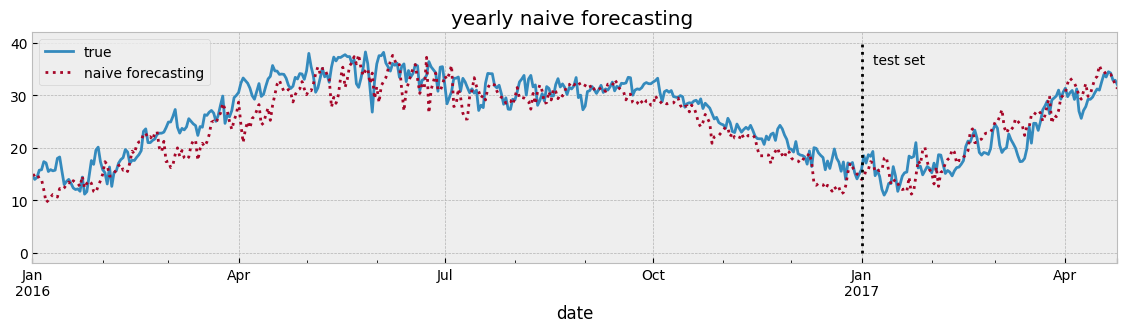

In [33]:
df_all['2016':]['temp'].plot(label = 'true' , figsize = (14,3))
df_naive['2016':]['temp'].plot(label = 'naive forecasting' , style = ':')
plt.vlines(x = '2017-01-01' , ymin = 0 , ymax = 40 , linestyles= ':' , colors='k')
plt.annotate(text = 'test set' , xy = ('2017-01-06' , 36))  # annotation coordinant 
plt.title('yearly naive forecasting ') 
plt.legend()
plt.show()

# ARIMA

### auto correlation function for ARIMA model and check stationary
we do this by auto correlation function (ACF) and partial (PACF)
auto correlation measure correlation between time series variable and its lagged values , linearly.
(compare data with laged data belong to one variable) , it used to determine q value (MA component hyper parameter)<br>
partial autocorrelation mesure todays value from specific lagged value , it is usedd to determine p value ( AR hyper parameter)<br>
and optimum value for p and q , is where auto correlation become close to zero.
decaying form of ACF , shows data is stationary.

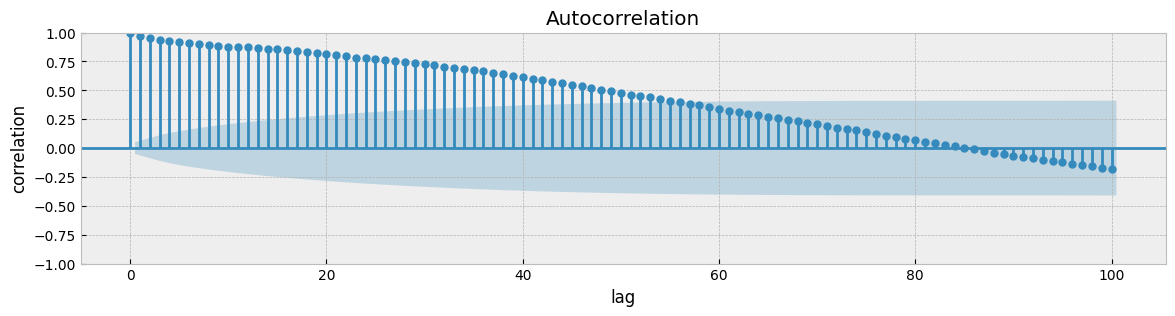

(Text(0.5, 28.0, 'lag'), Text(28.0, 0.5, 'correlation'), None)

In [34]:
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
fig , ax = plt.subplots(figsize = (14,3))
plot_acf(x = df['temp'] , ax = ax , lags=100)
plt.xlabel('lag') , plt.ylabel('correlation') , plt.show()

### hint for plot
for lag 0, correlation is always 1.<br>
lag 5 is 0.75 : means today value(temp) has +0.75 correlated with previous all 5 days. 

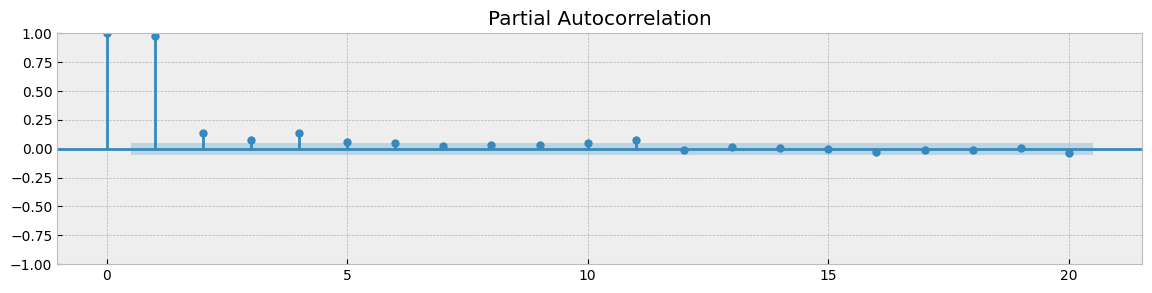

In [35]:
fig , ax = plt.subplots(figsize = (14,3))
plot_pacf(x = df['temp'] , ax = ax , lags=20)
plt.show()

### hint for plot
for lag 0, correlation is always 1. and for second lag , is same as ACF<br>
lag 5 is - 0.1 : means today value(temp) has -0.10 correlated compare to  5 days ago. <br>
**based on plot , after lag1 , correlation drops off significantly , best value for order of P in arima , is 1**

In [36]:
# exact value for acf , pacf , in case they are needed.
from statsmodels.tsa.stattools import pacf , acf
acf = acf(x = df_weekly['temp'] , nlags = 20)
pacf = pacf(x = df_weekly['temp'] , nlags=20)
#acf
#pacf

### modeling for daily time frame
### walk forward forecasting ( rolling window forecasting)
this model dynamicly train and update the model for every day <br>
**noticec : it takes time**    
    [original : start] is training data , we predicit on test set [start : end]

In [38]:
%%time
from statsmodels.tsa.arima.model import ARIMA
origin , start , end = '2013' , '2017-01-01' , '2017-04-24'
test_period = pd.date_range(start , end)
y_preds = []
for today in test_period.shift(-1):
    model_arima = ARIMA(df_all[origin : today]['temp'].asfreq('D'),
                   order = (1,1,1) , 
                   seasonal_order=(1,1,1,7))
    model_arima = model_arima.fit()
    y_pred = model_arima.forecast().iloc[0]
    y_preds.append(y_pred)

CPU times: total: 3min 22s
Wall time: 5min 21s


In [39]:
y_preds = pd.Series(y_preds , index = test_period)
y_true = df_all['temp'].loc[test_period]

In [40]:
score_sarima = metrics_3(y_true , y_preds , model = 'sarima')
score_sarima

{'model': 'sarima', 'mae': '1.33', 'mape': '6.65%', 'r2': '92.92%'}

In [41]:
model_performance.append(score_sarima)

# ETS
since there is trend and seasonality , we use Holt-winter exponential smoothing

In [42]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
ets_model = ExponentialSmoothing(df['temp'].asfreq('D') , trend = 'add' , seasonal= 'add' , seasonal_periods=365)
ets_model = ets_model.fit()

In [43]:
y_true = df_all['temp'].loc[test_period]
y_preds = ets_model.forecast(steps = len(data_test['temp']))

In [44]:
score_ets = metrics_3(y_true , y_preds , model = 'ETS')
score_ets

{'model': 'ETS', 'mae': '2.65', 'mape': '12.46%', 'r2': '72.41%'}

In [45]:
model_performance.append(score_ets)

# deep learning

### prepare data
#### multivariate modeling( all feature , temp , humidity , pressure , windspeed) for single target prediction(temp)

In [46]:
df_train = df[:'2016-05']
df_val = df['2016-06':]    # almost 15% of train data set as validation set
df_test = data_test.copy()
df_train.shape , df_val.shape , df_test.shape

((1247, 4), (215, 4), (114, 4))

### scaling datas

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dfs_train = scaler.fit_transform(df_train)
dfs_val = scaler.transform(df_val)   # validation and test set do not need to fit , they just need transform
dfs_test = scaler.transform(df_test)

### function of converting data to sequential form

In [48]:
def make_sequence(df , sequence_length):
    X = [] 
    target = []
    for i in range(len(df) - sequence_length):
        s = df[i : i + sequence_length]
        t = df[i+sequence_length , 0]  # temp 
        X.append(s)
        target.append(t)
    return np.array(X) , np.array(target)

In [49]:
# making sequence form for data , they contain 4  feature for ds and 1 feature for target(temp)
seq = 28     # sequential length , i choosed 4 week 
ds_train , target_train = make_sequence(dfs_train, sequence_length=seq)
ds_val , target_val = make_sequence(dfs_val ,sequence_length=seq)
ds_test , target_test = make_sequence(dfs_test, sequence_length=seq)
ds_train.shape , ds_val.shape , ds_test.shape

((1219, 28, 4), (187, 28, 4), (86, 28, 4))

# RNN

In [51]:
import tensorflow as tf
tf.random.set_seed(42)
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (seq , ds_train.shape[2])) ,
    tf.keras.layers.SimpleRNN(32 , activation = 'sigmoid'),
    tf.keras.layers.Dense(1)
])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss' , 
                                                  patience=10 , restore_best_weights=True)
model_rnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.02) , 
              loss = tf.keras.losses.MeanSquaredError() , 
              metrics = ['mae'])
model_rnn.summary()
history = model_rnn.fit(x = ds_train,y = target_train , validation_data=(ds_val , target_val),
                        epochs=100 , batch_size = 32 , callbacks=[early_stopping])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.6757 - mae: 0.6037 - val_loss: 0.1044 - val_mae: 0.2578
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0833 - mae: 0.2246 - val_loss: 0.0595 - val_mae: 0.1848
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0622 - mae: 0.1917 - val_loss: 0.0487 - val_mae: 0.1710
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0537 - mae: 0.1768 - val_loss: 0.0425 - val_mae: 0.1599
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0494 - mae: 0.1679 - val_loss: 0.0394 - val_mae: 0.1505
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0472 - mae: 0.1643 - val_loss: 0.0403 - val_mae: 0.1501
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0461 - mae: 0.1626 - val_loss: 0.0412 - val_mae: 0.1524
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0455 - mae: 0.1614 - val_loss: 0.0424 - val_mae: 0.1557
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.04

In [52]:
# result for sclaed data
val_loss , val_mae = model_rnn.evaluate(ds_val , target_val)
print(f'validation loss : {val_loss:0.2f} ')
print(f'validation mean absolute error : {(val_mae):0.3f} ')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451 - mae: 0.1623 
validation loss : 0.04 
validation mean absolute error : 0.150 


## originl MAE 
rescaling y_pred and y_true

upper mae is for scaled data , to get original loss and metrics and compare with other models(sarima , ets)<br>
**we need to rescale predicted value and get original mae**

### inverse function

In [54]:
# Function to inverse transform predictions and true values
def inverse_transform(y_true, y_pred, scaler):
    # Create a dummy array with the same number of columns as the original dataset
    dummy_pred = np.zeros((len(y_pred), scaler.n_features_in_))  # Same shape as transformed features
    dummy_true = np.zeros((len(y_true), scaler.n_features_in_))  # Same shape as transformed features
    
    # Assign the predicted and true values to the first column (target feature)
    dummy_pred[:, 0] = y_pred[:, 0]
    dummy_true[:, 0] = y_true
    
    # Inverse transform both predicted and true values
    y_pred_original = scaler.inverse_transform(dummy_pred)[:, 0]
    y_true_original = scaler.inverse_transform(dummy_true)[:, 0]
  
    return  y_true_original, y_pred_original 

## results

In [55]:
# original val eval
y_pred = model_rnn.predict(ds_val)
y_true_original_rnn , y_pred_original_rnn= inverse_transform(target_val, y_pred , scaler )
metrics_3(y_true_original_rnn , y_pred_original_rnn , 'RNN_val')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


{'model': 'rnn_val', 'mae': '1.12', 'mape': '4.58%', 'r2': '92.98%'}

In [88]:
# original test eval
y_pred = model_rnn.predict(ds_test)
y_true_original_rnn , y_pred_original_rnn= inverse_transform(target_test, y_pred ,  scaler )
score_rnn = metrics_3(y_true_original_rnn , y_pred_original_rnn , 'RNN')
score_rnn

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


{'model': 'RNN', 'mae': '1.39', 'mape': '6.37%', 'r2': '91.16%'}

In [89]:
model_performance.append(score_rnn)

### visualization
#### loss curve | metric curve | predict vs real

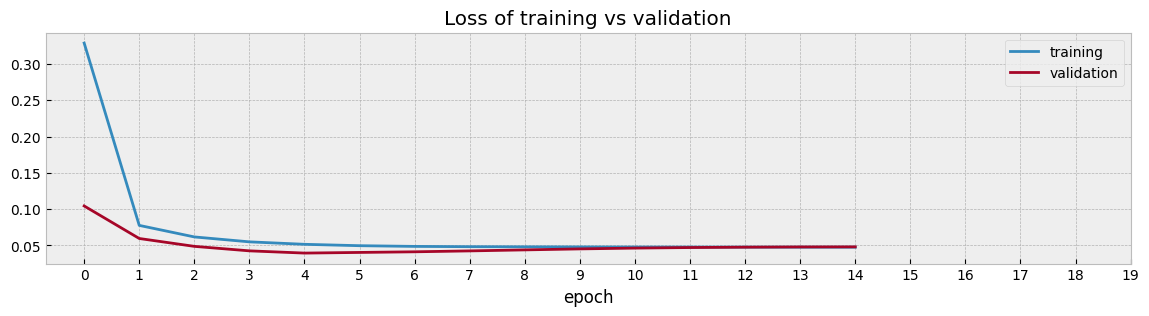

In [59]:
plt.figure(figsize = (14,3))
plt.plot(history.history['loss'] , label = 'training')
plt.plot(history.history['val_loss'] , label = 'validation')
plt.title('Loss of training vs validation') 
plt.legend() 
plt.xticks(range(20)), plt.xlabel('epoch')  
plt.show()

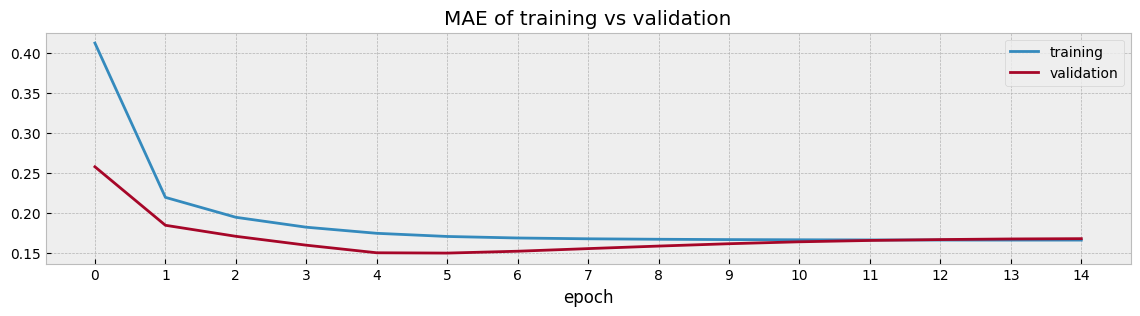

In [60]:
plt.figure(figsize = (14,3))
plt.plot(history.history['mae'] , label = 'training')
plt.plot(history.history['val_mae'] , label = 'validation')
plt.title('MAE of training vs validation')
plt.legend() , plt.xticks(range(15)) , plt.xlabel('epoch') 
plt.show()

model isn't overfitted or underfitted , it reach minimum local after 14 epochs.(early stopping)

    y_true_original_rnn = df_test['temp']
    but it is in sequential format

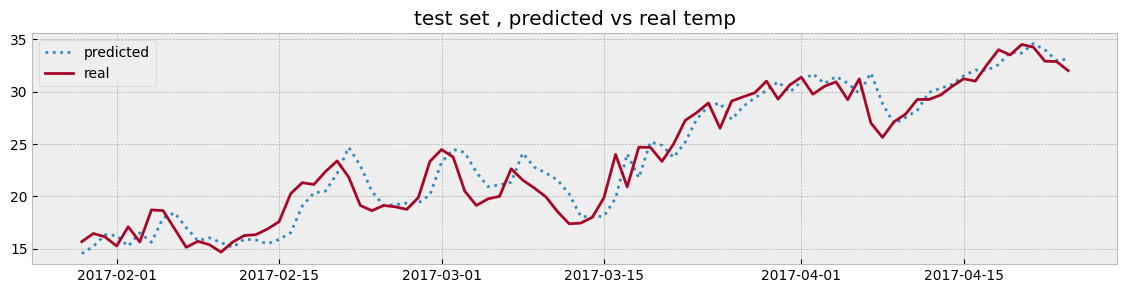

In [61]:
plt.figure(figsize = (14,3))
plt.plot(df_test.index[seq:], y_pred_original_rnn , linestyle = ':' , label = 'predicted')
plt.plot(df_test.index[seq:] ,y_true_original_rnn  , label = 'real')
plt.legend()
plt.title('test set , predicted vs real temp')
plt.show()

## LSTM

In [62]:
tf.random.set_seed(42)
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (seq , 4)) ,
    tf.keras.layers.LSTM(32 , activation = 'sigmoid'),
    tf.keras.layers.Dense(1)
])
model_lstm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.02) , 
              loss = tf.keras.losses.MeanSquaredError() , 
              metrics = ['mae'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss' , 
                                                  patience=10 , restore_best_weights=True)
history = model_lstm.fit(x = ds_train, y = target_train , validation_data=(ds_val , target_val),
                        epochs=100 , batch_size = 32 , callbacks=[early_stopping])

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4370 - mae: 0.5069 - val_loss: 0.0595 - val_mae: 0.1830
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0644 - mae: 0.1985 - val_loss: 0.0550 - val_mae: 0.1779
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0542 - mae: 0.1804 - val_loss: 0.0465 - val_mae: 0.1644
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0496 - mae: 0.1706 - val_loss: 0.0420 - val_mae: 0.1573
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0466 - mae: 0.1637 - val_loss: 0.0416 - val_mae: 0.1572
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0448 - mae: 0.1606 - val_loss: 0.0435 - val_mae: 0.1603
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0440 - mae: 0.1590 - val_loss: 0.0443 - val_mae: 0.1616
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0435 - mae: 0.1581 - val_loss: 0.0449 - val_mae: 0.1627
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.04

In [63]:
# scaled data result
val_loss , val_mae = model_lstm.evaluate(ds_val , target_val)
print(f'validation loss : {val_loss:0.2f} ')
print(f'validation mean absolute error : {(val_mae):0.3f} ')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0455 - mae: 0.1667 
validation loss : 0.04 
validation mean absolute error : 0.157 


### result

In [65]:
# original validation matrics
y_pred = model_lstm.predict(ds_val)
y_true_original_lstm , y_pred_original_lstm = inverse_transform(target_val , y_pred , scaler)
metrics_3(y_true_original_lstm , y_pred_original_lstm , 'lstm val')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


{'model': 'lstm val', 'mae': '1.17', 'mape': '4.87%', 'r2': '92.59%'}

In [86]:
# original test set matrics
y_pred = model_lstm.predict(ds_test)
y_true_original_lstm , y_pred_original_lstm = inverse_transform(target_test , y_pred , scaler)
score_lstm = metrics_3(y_true_original_lstm , y_pred_original_lstm , 'LSTM')
score_lstm

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


{'model': 'LSTM', 'mae': '1.44', 'mape': '6.64%', 'r2': '91.21%'}

In [87]:
model_performance.append(score_lstm)

### visualization
#### loss curve | metric curve | predict vs real

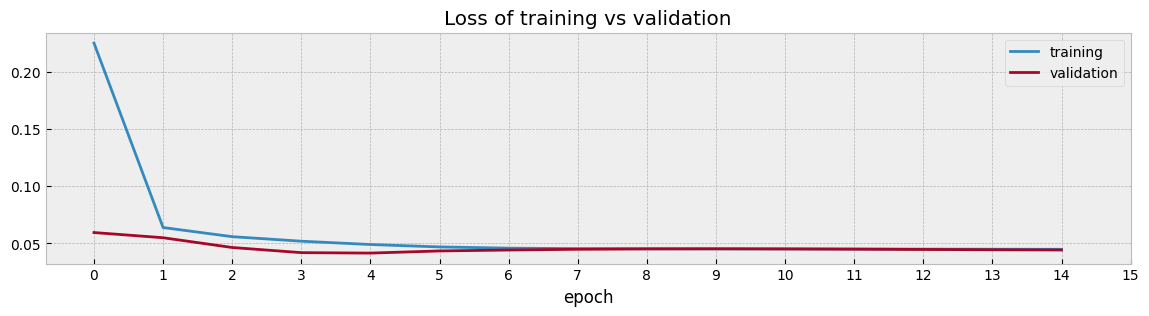

In [68]:
plt.figure(figsize = (14,3))
plt.plot(history.history['loss'] , label = 'training')
plt.plot(history.history['val_loss'] , label = 'validation')
plt.title('Loss of training vs validation') 
plt.legend() 
plt.xticks(range(16)) , plt.xlabel('epoch') 
plt.show()

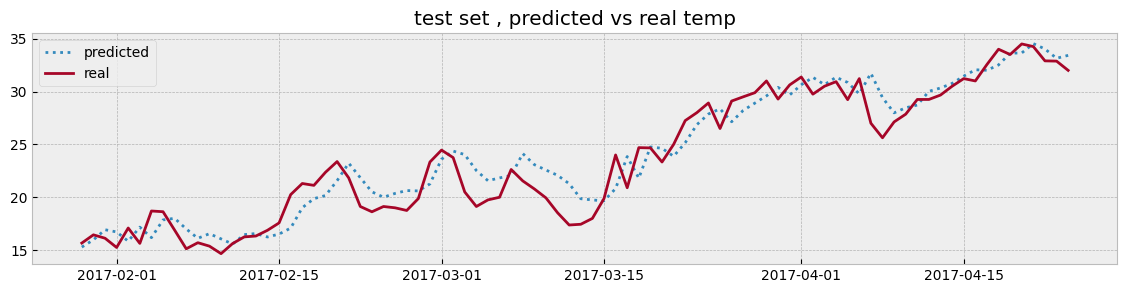

In [69]:
plt.figure(figsize = (14,3))
plt.plot(df_test.index[seq:], y_pred_original_lstm , linestyle = ':' , label = 'predicted')
plt.plot(df_test.index[seq:] ,y_true_original_lstm  , label = 'real')
plt.legend()
plt.title('test set , predicted vs real temp')
plt.show()

# compare models performances

In [114]:
model_performance

[{'model': 'naive', 'mae': '2.56', 'mape': '11.12%', 'r2': '80.45%'},
 {'model': 'sarima', 'mae': '1.33', 'mape': '6.65%', 'r2': '92.92%'},
 {'model': 'ETS', 'mae': '2.65', 'mape': '12.46%', 'r2': '72.41%'},
 {'model': 'LSTM', 'mae': '1.44', 'mape': '6.64%', 'r2': '91.21%'},
 {'model': 'RNN', 'mae': '1.39', 'mape': '6.37%', 'r2': '91.16%'}]

In [115]:
# the values of model performance are object with'%' 
# we need to replce and convert them to float for plotting
df_performance = pd.DataFrame(model_performance)
df_performance['mae'] = df_performance['mae'].astype(float)
df_performance['mape'] = df_performance['mape'].str.replace('%', '').astype(float)
df_performance['r2'] = df_performance['r2'].str.replace('%', '').astype(float)
df_performance

,model,mae,mape,r2
0,naive,2.56,11.12,80.45
1,sarima,1.33,6.65,92.92
2,ETS,2.65,12.46,72.41
3,LSTM,1.44,6.64,91.21
4,RNN,1.39,6.37,91.16


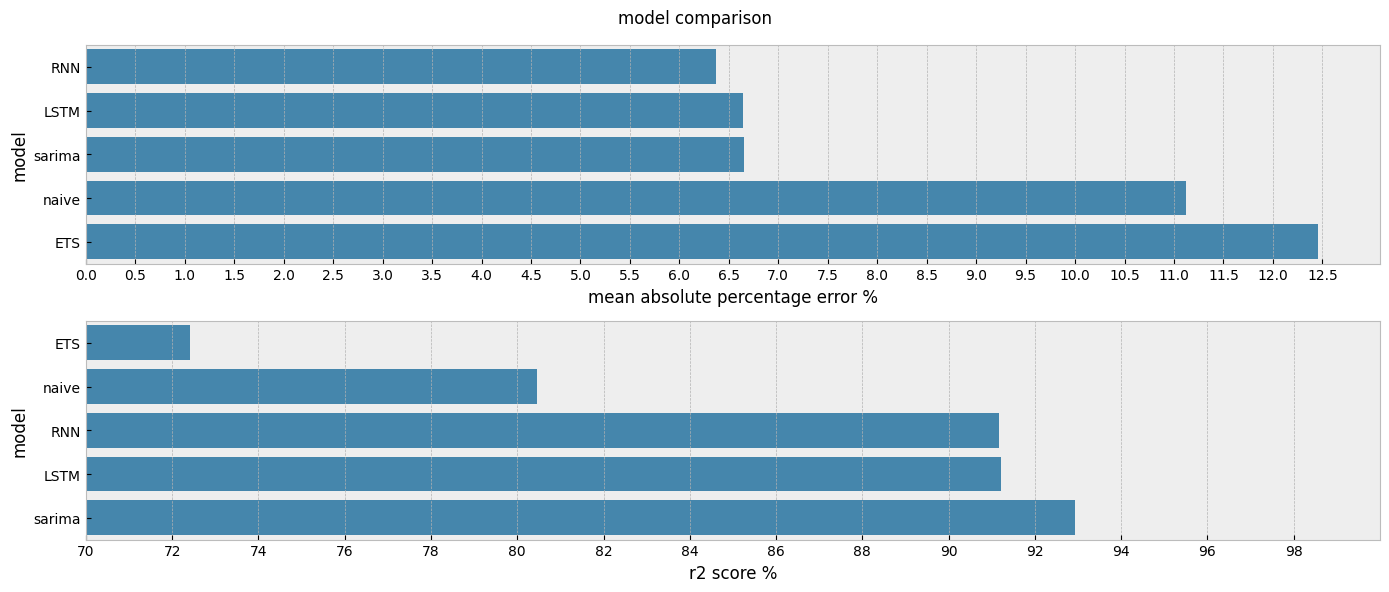

In [116]:
fig , ax = plt.subplots(2,1,figsize=(14,6))
sns.barplot(df_performance.sort_values(by = 'mape') ,x ='mape' ,y = 'model' , ax = ax[0])
sns.barplot(df_performance.sort_values(by = 'r2') ,x ='r2' ,y = 'model' , ax = ax[1])
ax[0].set_xlabel('mean absolute percentage error %' ) , ax[0].set_xticks(np.arange(0,13,0.5))
ax[1].set_xlabel('r2 score %') , ax[1].set_xticks(np.arange(50,100,2)) , ax[1].set_xlim(70,100)
plt.suptitle('model comparison')
plt.tight_layout()
plt.show()

# conclusion

*ETS( Exponential smoothing)* model was predicted as direct method , it means , it trained on training data , then model do prediction on test set ,and it is even weaker than *naive forecasting* which is benchmark .<br> we did not use walk-forward . I am sure in case of walk-forward method , the performance of ETS would be higher , i did to compare walk-forward(which we did for SARIMA ) and direct method forecasting.<br>

there is trade off , when we use walkforward method to forecast , runnig time increase too much , but we gain accuracy.

I used walk forward model for *SARIMA (seasonal arima)* , so it is much better score , but very slow to compute , and we have highest r2 score .<br>
*RNN and LSTM* are very close togheter , almoste the same<br>
the share almost 6.5% for mean absolouter percentage error.<br>
and 93% r2 score for sarima , 91% for deep learning algorithms

a published article <br>
*by Gers, et al. in 2001 titled Applying LSTM to Time Series Predictable through Time-Window Approaches*<br>
it shown for univariate models , lstm and rnn have poorly performance , and othera methods like ARIMA family and Exponential smoothing act better.but as we see , in multivariate models ( like this dataset) deep learning algorithms had a good performance.
